In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Environment import Environment
from Agent import Agent
import numpy as np
from plot import plot
from Display import disp
from termcolor import colored
from tqdm import tqdm
from math import log, exp

2023-09-09 03:10:31.100428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 03:10:32.426743: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def run(episodes: int, iterations: int, env=None, agent=None, method="Episods_Iterations"):
    sigma = 1e-2
    if env == None:
        env = Environment(num_of_antennas=10, num_of_irs1=10, num_of_irs2=10,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

        U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=False, los_to_irs1=False,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

        U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)
    

    num_of_actions = env.M1 + env.M2 + len(env.Users) * env.N + env.num_of_users - 1

    if agent == None:
        agent = Agent(num_states=env.num_of_users, bound=1, batch_size=128, max_size=100000,
                        env=env, n_actions=num_of_actions,
                        noise=0.02, alpha=0.0002, beta=0.0004, fc1=512, fc2=256)


    num_of_episodes = episodes
    num_of_iterations = iterations

    score_history = np.zeros((num_of_episodes,))
    rewards = np.zeros((num_of_episodes, num_of_iterations))
    sumrate = np.zeros((num_of_episodes, num_of_iterations))
    U1_SINR = np.zeros((num_of_episodes, num_of_iterations))
    U2_SINR = np.zeros((num_of_episodes, num_of_iterations))

    Old_Avg = 0
    # obs = env.State()

    for ep in range(num_of_episodes):
        score = 0
        obs = env.State()

        if ep < num_of_episodes / 5:
            agent.noise = 0.5
        elif ep < num_of_episodes * 2 / 5:
            agent.noise = 0.4
        elif ep < num_of_episodes * 3 / 5:
            agent.noise = 0.3
        elif ep < num_of_episodes * 4 / 5:
            agent.noise = 0.2
        elif ep < num_of_episodes - 5 :
            agent.noise = 0.1
        else:
            agent.noise = 0.001


        # agent.noise = (0.5) / (ep + 1) 
        for iter in range(num_of_iterations):
            
            action = agent.choose_action(obs)

            new_state, reward, sumrate[ep][iter], SINRs = env.Step(action)
            # if reward != 0 : 
            agent.remember(obs, action, reward, new_state)
                
            agent.learn()
            obs = new_state
            score += reward
            rewards[ep][iter] = reward

            U1_SINR[ep][iter] = SINRs[0]
            U2_SINR[ep][iter] = SINRs[1]

        # agent.learn()
        score = score / num_of_iterations
        score_history[ep] = score
        New_Avg = score_history[:ep + 1].mean()

        disp(episod=ep, score=score, score_history=score_history,
                New_Avg=New_Avg, Old_Avg=Old_Avg, SINRs=SINRs, sumrate=sumrate[ep][iter])
        
        ac = np.array(action)
        power_noise = np.array(agent.power_noise)
        print("Power split factor = "+ colored(f"{ac[-1 : ][0]: <5.2}", "blue") +
            "| Power noise = " + colored(f"{power_noise[-1]: <5.2}", "blue") )
        
        # print(agent.memory.buffer_counter)

        # obs = env.Reset()
        Old_Avg = New_Avg

    plot(score_history=score_history, sumrate=sumrate,
            u1_sinr=U1_SINR, u2_sinr=U2_SINR, mean=False,
            title=f"N = {env.N}, M1 = {env.M1}, M2 = {env.M2}", method=method)
    
    return agent
    

In [4]:
def run2(iterations: int, variable_noise:bool, env=None, agent=None, method="Iterations_Only", isplot:bool = True,
    alpha:float = 0.0002, beta:float = 0.0004, noise:float = 0.02, batch_size:int = 128, warmup:int = 0,
    uniform_selection:bool=True, TD3:bool=False, TD3_update_interval:int=2, last_layer_activation:str="sigmoid",
    multi_actor:bool=False, multi_out_layer:bool = False, reward_function:str = "product*sumrate"):

    sigma = 1e-2

    if env == None : 
        env = Environment(num_of_antennas=10, num_of_irs1=10, num_of_irs2=10,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

        U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=False, los_to_irs1=False,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

        U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)
        

    num_of_actions = env.M1 + env.M2 + len(env.Users) * env.N + env.num_of_users - 1

    if agent == None :
        agent = Agent(num_states=env.num_of_users, bound=2, batch_size=batch_size, max_size=100000,
                        env=env, n_actions=num_of_actions, warmup=warmup,uniform_selection=uniform_selection,
                        noise=0.055, alpha=alpha, beta=beta, fc1=512, fc2=256, TD3=TD3, TD3_update_interval=TD3_update_interval,
                        last_layer_activation=last_layer_activation, multi_actor=multi_actor, multi_out_layer=multi_out_layer)


    num_of_iterations = iterations
    rewards = np.zeros((1, num_of_iterations))
    sumrate = np.zeros((1, num_of_iterations))
    U1_SINR = np.zeros((1, num_of_iterations))
    U2_SINR = np.zeros((1, num_of_iterations))

    obs = env.State()

    for iter in tqdm(range(num_of_iterations), desc= colored("Agent is Learning \U0001f600 ", "green"), ncols=123, colour= "red"):


        if variable_noise :
            if iter < num_of_iterations / 2:
                agent.noise = (0.5) * exp(-(iter / num_of_iterations) ** 1)

            else:
                agent.noise = (0.5) * exp(-(iter / (num_of_iterations/2)) ** 1.8)
        else:
            agent.noise = noise

        action = agent.choose_action(obs)

        new_state, reward, sumrate[0][iter], SINRs = env.Step(action)
        # if reward != 0 : 
        agent.remember(obs, action, reward, new_state)
            
        agent.learn()
        obs = new_state
        rewards[0][iter] = reward
        U1_SINR[0][iter] = SINRs[0]
        U2_SINR[0][iter] = SINRs[1]

    last_sumrate, last_u1_sinr, last_u2_sinr = plot(score_history=np.array([1]), sumrate=sumrate,
            u1_sinr=U1_SINR, u2_sinr=U2_SINR, mean=False,
            title=f"N = {env.N}, M1 = {env.M1}, M2 = {env.M2}", method=method, isplot=isplot)

    return agent, last_sumrate, last_u1_sinr, last_u2_sinr


In [29]:
num_of_runs = 5
average_sumrate_1 = 0
average_sumrate_2 = 0
average_sumrate_3 = 0
average_sumrate_4 = 0
sigma = 1e-2

for _ in range(num_of_runs):

       env1 = Environment(num_of_antennas=10, num_of_irs1=30, num_of_irs2=10,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1, reward_function="product*sumrate",
                            state_dB=False)

       U11 = env1.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                                   noise_var=sigma**2, los_to_antenna=False, los_to_irs1=True,
                                   los_to_irs2=False, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)

       U21 = env1.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)

       env2 = env1.copy()
       # env3 = env1.copy()
       # env4 = env1.copy()

       # env2.Users[0].weight = 2
       env2.state_dB = True


       # env1.reward_function = "man3"
       # env2.reward_function = "man"
       # env3.reward_function = "man4"
       # env4.reward_function = "product"


       agent1, last_sumrate1, last_u1_sinr1, last_u2_sinr1 = run2(2000, variable_noise=True, env=env1, isplot=False, alpha=0.0002,
                                   beta=0.0004, batch_size=128, multi_actor=True)

       agent2, last_sumrate2, last_u1_sinr2, last_u2_sinr2 = run2(2000, variable_noise=True, env=env2, isplot=False, alpha=0.0002,
                                   beta=0.0004, batch_size=128, multi_out_layer=True)

       # agent3, last_sumrate3, last_u1_sinr3, last_u2_sinr3 = run2(2000, variable_noise=True, env=env3, isplot=False, alpha=0.0002,
       #                             beta=0.0004, batch_size=128, multi_actor=True)

       # agent4, last_sumrate4, last_u1_sinr4, last_u2_sinr4 = run2(2000, variable_noise=True, env=env4, isplot=False, alpha=0.0002,
       #                             beta=0.0004, batch_size=128, multi_actor=True)


       average_sumrate_1 += last_sumrate1
       average_sumrate_2 += last_sumrate2
       # average_sumrate_3 += last_sumrate3
       # average_sumrate_4 += last_sumrate4

       print(f"Sumrate_1 = {last_sumrate1 : < 10.3} U1_Rate_1 = {np.log2(1 + last_u1_sinr1) : < 10.3}\
       U2_Rate_1 = {np.log2(1+  last_u2_sinr1) : < 10.3}")

       print(f"Sumrate_2 = {last_sumrate2 : < 10.3} U1_Rate_2 = {np.log2(1 + last_u1_sinr2) : < 10.3}\
       U2_Rate_2 = {np.log2(1 + last_u2_sinr2) : < 10.3}")

       # print(f"Sumrate_3 = {last_sumrate3 : < 10.3} U1_Rate_3 = {np.log2(1 + last_u1_sinr3) : < 10.3}\
       # U2_Rate_3 = {np.log2(1 + last_u2_sinr3) : < 10.3}")

       # print(f"Sumrate_4 = {last_sumrate4 : < 10.3} U1_Rate_4 = {np.log2(1 + last_u1_sinr4) : < 10.3}\
       # U2_Rate_4 = {np.log2(1 + last_u2_sinr4) : < 10.3}")
       
       print("\n")
      
average_sumrate_1 /= num_of_runs
average_sumrate_2 /= num_of_runs
average_sumrate_3 /= num_of_runs
average_sumrate_4 /= num_of_runs


# print(f"Avg 1 = {average_answ1 : < 5.2}")
print(f"Avg 1 = {average_sumrate_1 : < 10.3}\nAvg 2 = {average_sumrate_2 : < 10.3}\nAvg 3 = {average_sumrate_3 : < 10.3}\nAvg 4 = {average_sumrate_4 : < 10.3}")

Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:24<00:00, 23.72it/s]


Sumrate_1 =  5.33      U1_Rate_1 =  1.73            U2_Rate_1 =  3.61     
Sumrate_2 =  1.03      U1_Rate_2 =  0.345           U2_Rate_2 =  0.926    




Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:26<00:00, 23.01it/s]


Sumrate_1 =  1.4       U1_Rate_1 =  0.0595          U2_Rate_1 =  1.35     
Sumrate_2 =  5.82      U1_Rate_2 =  1.82            U2_Rate_2 =  4.0      




Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.72it/s]


Sumrate_1 =  5.5       U1_Rate_1 =  1.85            U2_Rate_1 =  3.66     
Sumrate_2 =  2.55      U1_Rate_2 =  0.0189          U2_Rate_2 =  2.54     




Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.36it/s]


Sumrate_1 =  5.23      U1_Rate_1 =  2.1             U2_Rate_1 =  3.14     
Sumrate_2 =  0.811     U1_Rate_2 =  0.304           U2_Rate_2 =  0.542    




Agent is Learning 😀 :  77%|█████████████████████████████████████████████▎             | 1534/2000 [01:15<00:22, 20.42it/s]


KeyboardInterrupt: 

In [ ]:
last_sumrate1

[0.0, 0.07519281216260215]

Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:32<00:00, 21.68it/s]


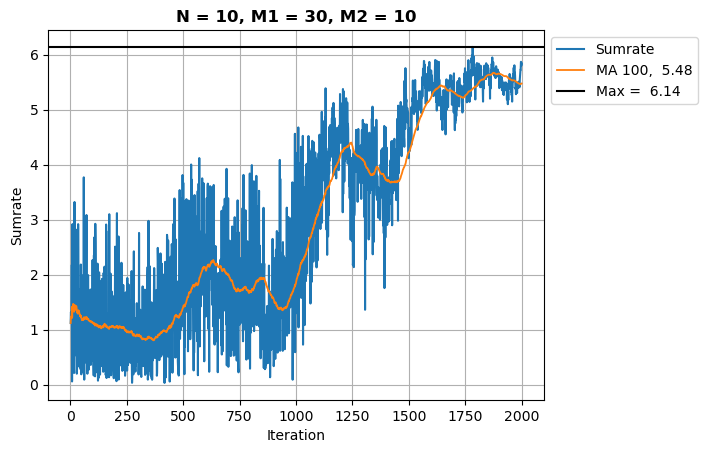

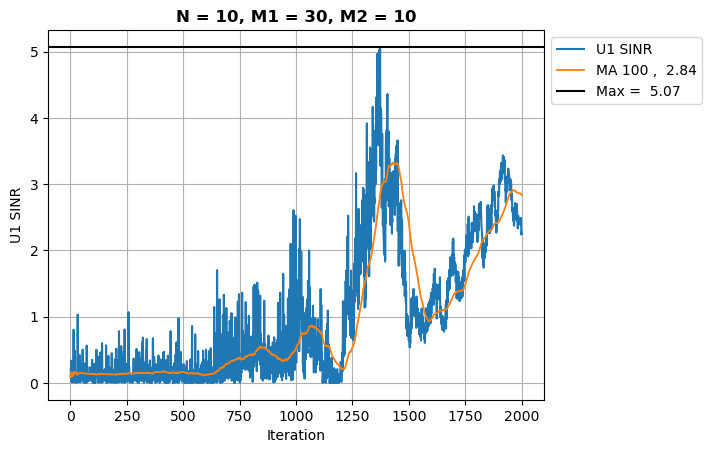

/home/danesh/Desktop/IRS-Project/src/plot.py:104: RuntimeWarning: divide by zero encountered in log10
  np.log10(u1_sinr), linewidth=1.5, label='U1 SINR')


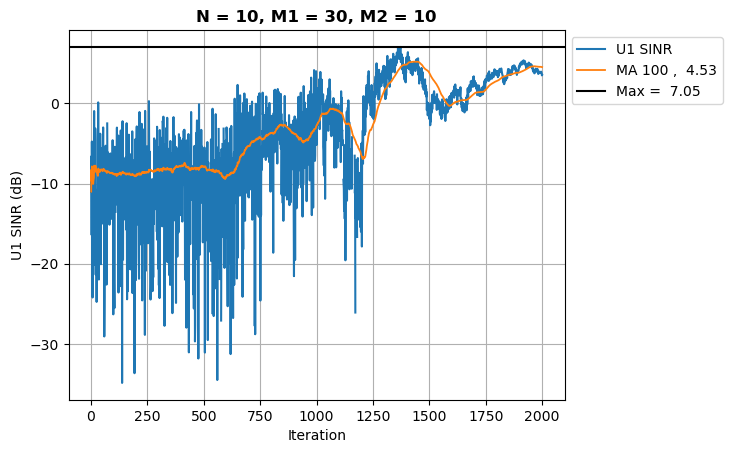

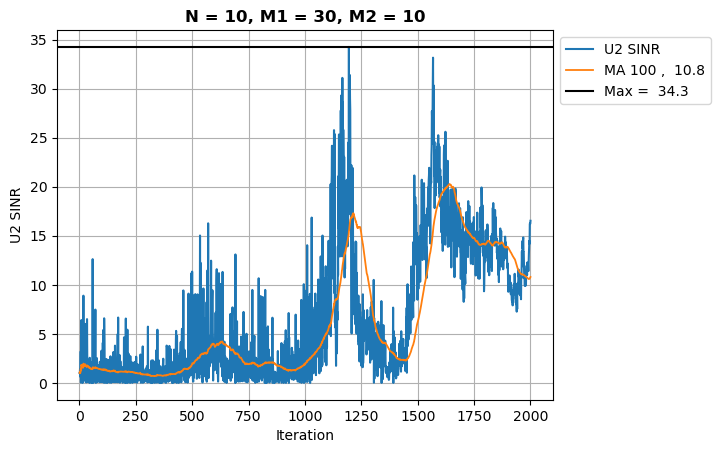

/home/danesh/Desktop/IRS-Project/src/plot.py:168: RuntimeWarning: divide by zero encountered in log10
  np.log10(u2_sinr), linewidth=1.5, label='U2 SINR')


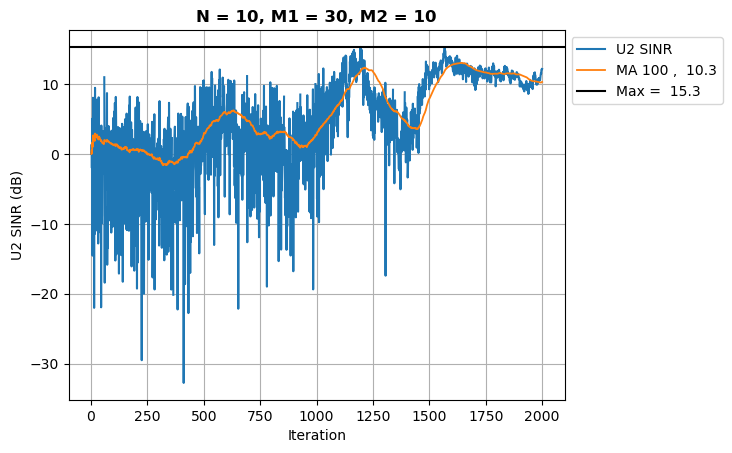

In [16]:
sigma = 1e-2
env1 = Environment(num_of_antennas=10, num_of_irs1=30, num_of_irs2=10,
                    path_loss_exponent=2, irs1_to_antenna=20,
                    irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1, reward_function="product*sumrate")

U11 = env1.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=False, los_to_irs1=True,
                            los_to_irs2=False, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)

U21 = env1.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                    noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                    los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)


# env1.reward_function = "man3"

agent1, last_sumrate1, last_u1_sinr1, last_u2_sinr1 = run2(2000, variable_noise=True, env=env1, isplot=True, alpha=0.0002,
                                   beta=0.0004, batch_size=128, multi_actor=True,)



Agent is Learning 😀 : 100%|█████████████████████████████████████████████████████████| 15000/15000 [05:16<00:00, 47.45it/s]


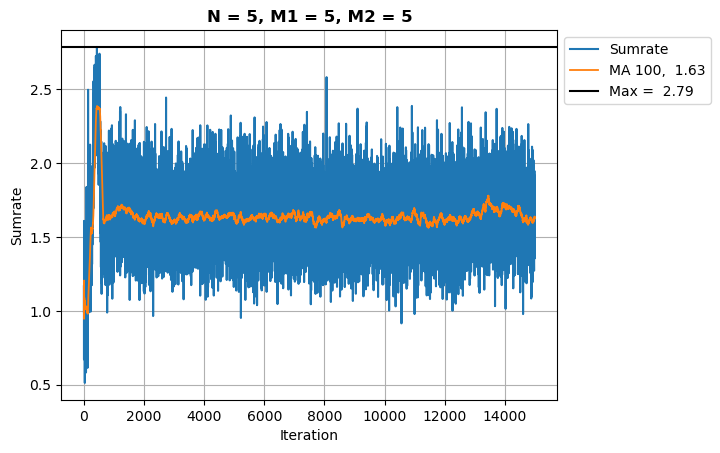

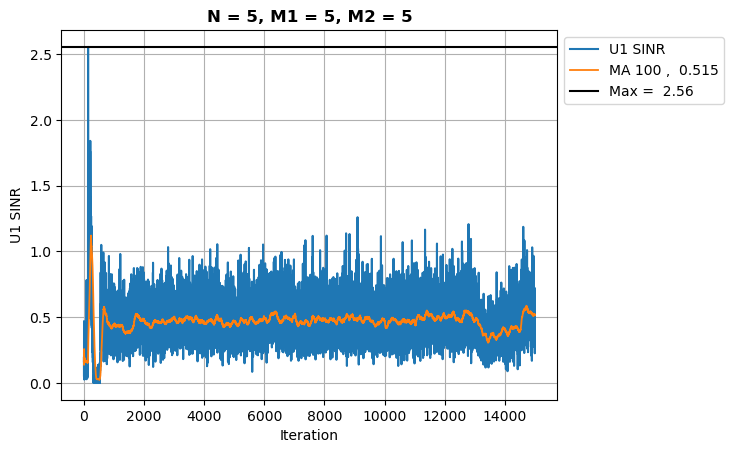

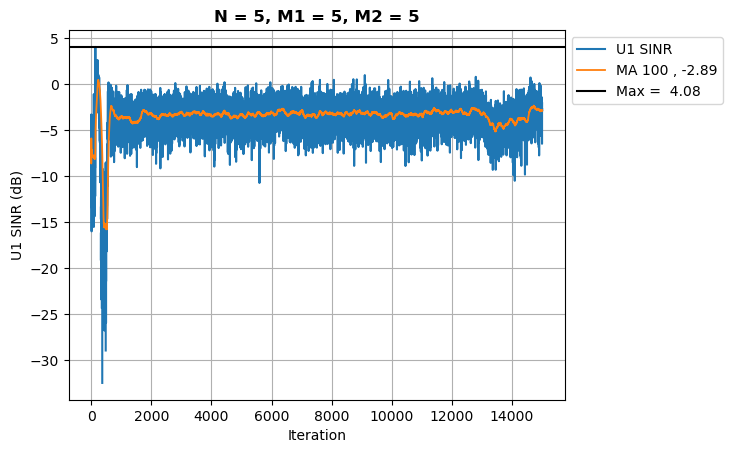

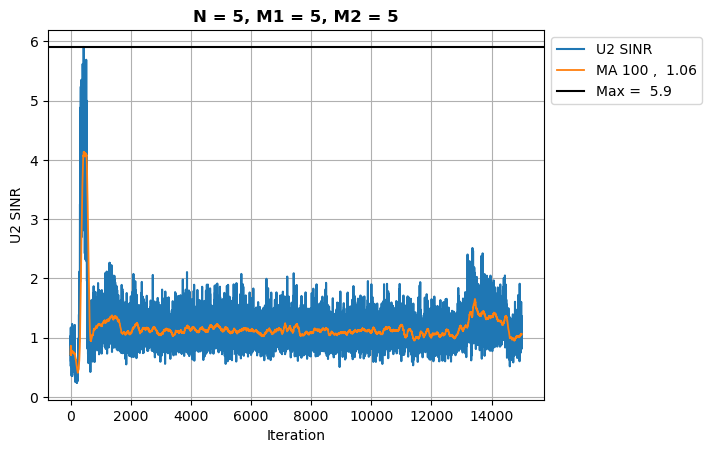

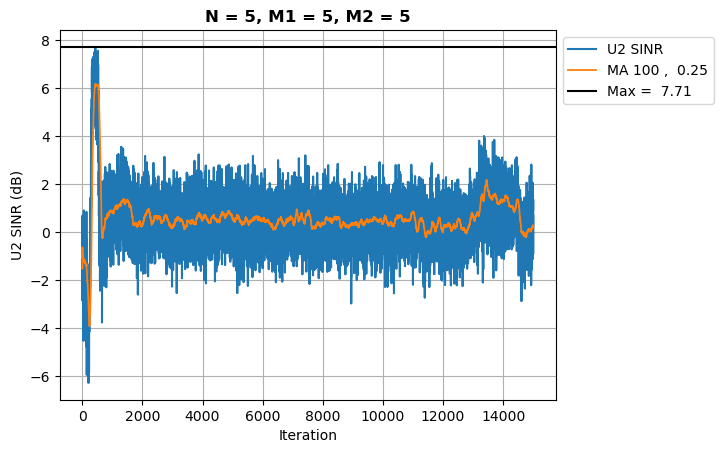

In [ ]:
agent, last_MA = run2(15000, variable_noise=False, env=env2, isplot=True, alpha=0.0007, beta=0.001, noise=0.055)

In [61]:
num_of_runs = 5
average_answ1 = 0
average_answ2 = 0
sigma1 = 0.01
sigma2 = 0.01

for _ in range(num_of_runs):

    env1 = Environment(num_of_antennas=10, num_of_irs1=5, num_of_irs2=5,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

    U11 = env1.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                                noise_var=sigma1**2, los_to_antenna=True, los_to_irs1=True,
                                los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

    U21 = env1.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                        noise_var=sigma1**2, los_to_antenna=True, los_to_irs1=True,
                        los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)
    #-------------------------------------------------------------------------------------------------------

    env2 = Environment(num_of_antennas=2, num_of_irs1=5, num_of_irs2=5,
                                path_loss_exponent=2, irs1_to_antenna=20,
                                irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

    U12 = env2.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                                noise_var=sigma2**2, los_to_antenna=True, los_to_irs1=True,
                                los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

    U22 = env2.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                        noise_var=sigma2**2, los_to_antenna=True, los_to_irs1=True,
                        los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

    # env2.Hs1 = env1.Hs1
    # env2.Hs2 = env1.Hs2
    # env2.H12 = env1.H12
    # env2.H21 = env1.H21
    # env2.Psi1 = env1.Psi1
    # env2.Psi2 = env1.Psi2

    # U12.h1u = U11.h1u
    # U12.hsu = U11.hsu
    # U12.h2u = U11.h2u
    # U12.w = U11.w

    # U22.h1u = U21.h1u
    # U22.hsu = U21.hsu
    # U22.h2u = U21.h2u
    # U22.w = U21.w
    
    agent1, last_MA1 = run2(2000, variable_noise=True, env=env1, isplot=False, alpha=0.0002, beta=0.0004, batch_size=128)
    agent2, last_MA2 = run2(2000, variable_noise=False, env=env2, isplot=False, alpha=0.0002, beta=0.0004, batch_size=128)


    average_answ1 += last_MA1
    average_answ2 += last_MA2

    print(f"Sumrate_1 = {last_MA1 : < 5.2}")
    print(f"Sumrate_2 = {last_MA2 : < 5.2}")

average_answ1 /= num_of_runs
average_answ2 /= num_of_runs

# print(f"Avg 1 = {average_answ1 : < 5.2}")
print(f"Avg 1 = {average_answ1 : < 5.2} & Avg 2 = {average_answ2 : < 5.2}")

Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 48.89it/s]


Sumrate_1 =  7.4 
Sumrate_2 =  3.0 


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [00:41<00:00, 48.70it/s]


Sumrate_1 =  7.8 
Sumrate_2 =  1.3 


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.33it/s]


Sumrate_1 =  7.9 
Sumrate_2 =  3.6 


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 48.92it/s]


Sumrate_1 =  8.2 
Sumrate_2 =  1.4 


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.34it/s]


Sumrate_1 =  0.96
Sumrate_2 =  1.2 
Avg 1 =  6.5  & Avg 2 =  2.1 


In [85]:
agent1.memory.buffer_counter
agent2.memory.buffer_counter

2000

In [30]:
num_of_runs = 5
average_answ = 0
sigma = 1e-4

for _ in range(num_of_runs):
    env = Environment(num_of_antennas=5, num_of_irs1=5, num_of_irs2=5,
                                path_loss_exponent=2, irs1_to_antenna=20,
                                irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=0.01)

    U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                                noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                                los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

    U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                        noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                        los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)
    


    agent, last_MA = run2(2000, variable_noise=True, env=env1, isplot=False, alpha=0.001, beta=0.001)

    average_answ += last_MA

    print(f"Sumrate = {last_MA : < 5.2}")

average_answ /= num_of_runs

print(average_answ)

Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 50.20it/s]


Sumrate =  1.6 


Agent is Learning 😀 :  58%|██████████████████████████████████▏                        | 1160/2000 [00:26<00:19, 43.09it/s]


KeyboardInterrupt: 

Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.57it/s]


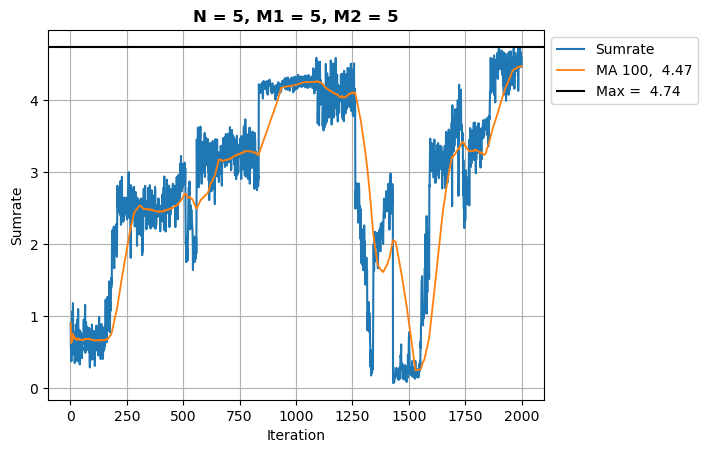

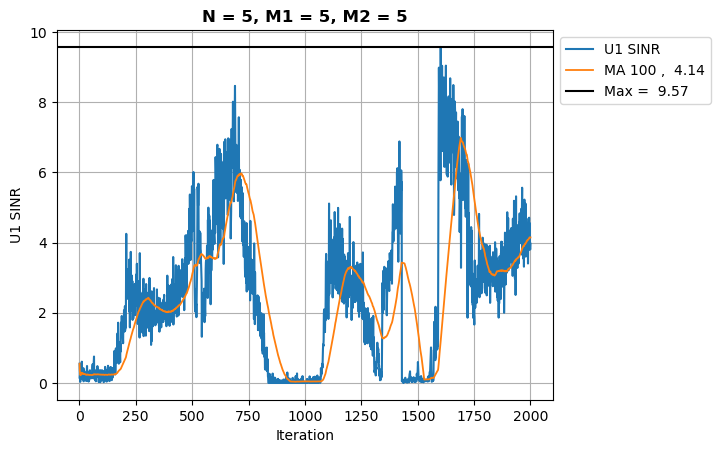

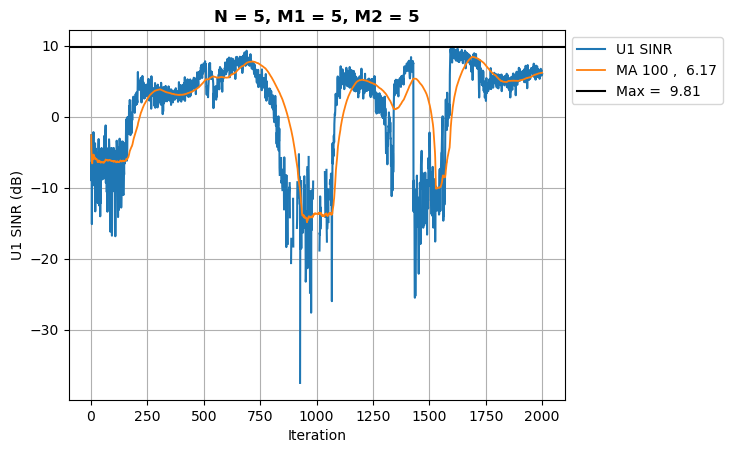

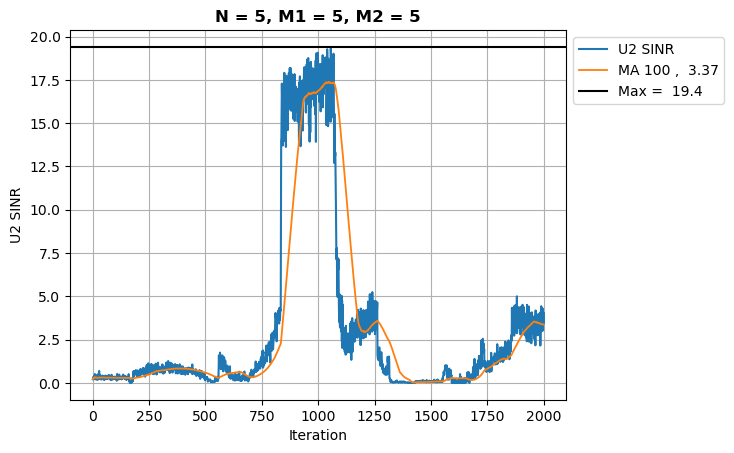

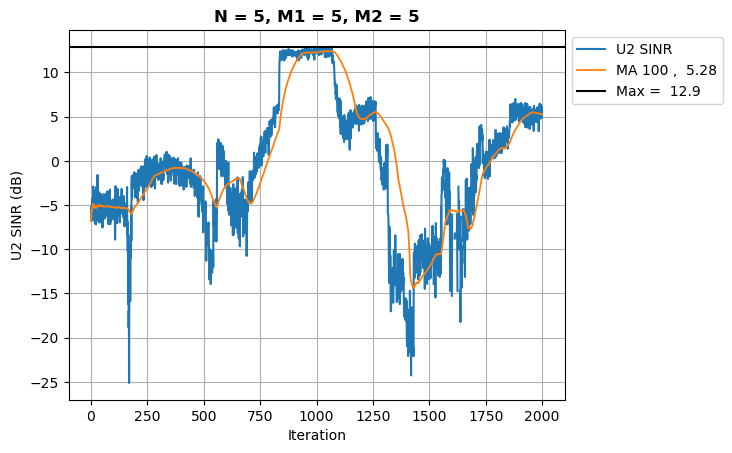

In [78]:
agent1 = run2(2000, variable_noise=False, env=env2)

Agent is Learning :) : 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.44it/s]


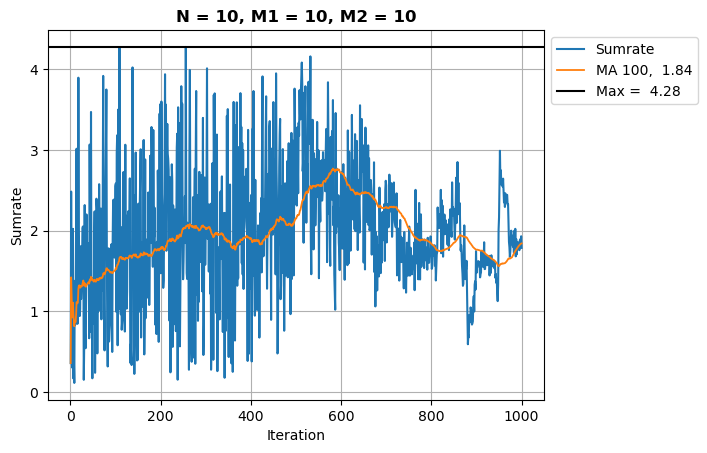

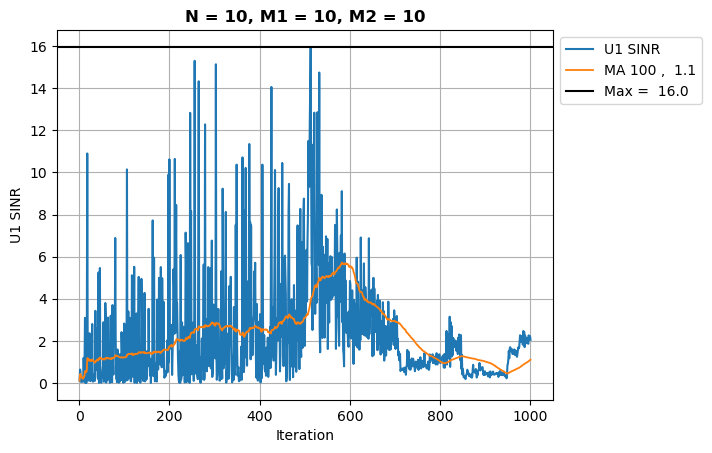

/home/danesh/Desktop/IRS-Project/src/plot.py:88: RuntimeWarning: divide by zero encountered in log10
  np.log10(u1_sinr), linewidth=1.5, label='U1 SINR')


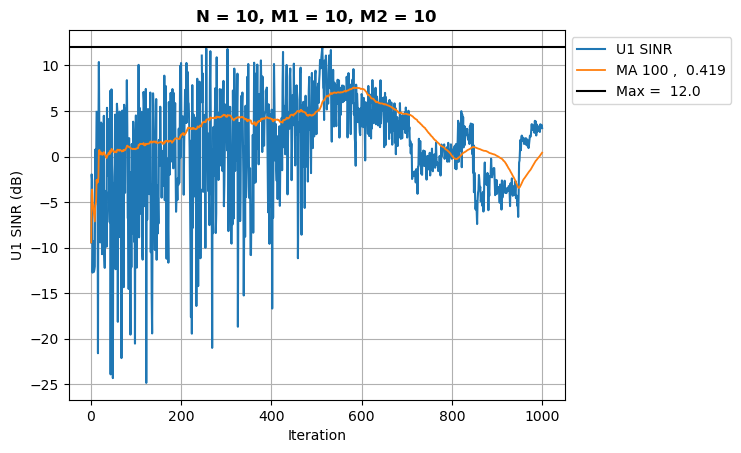

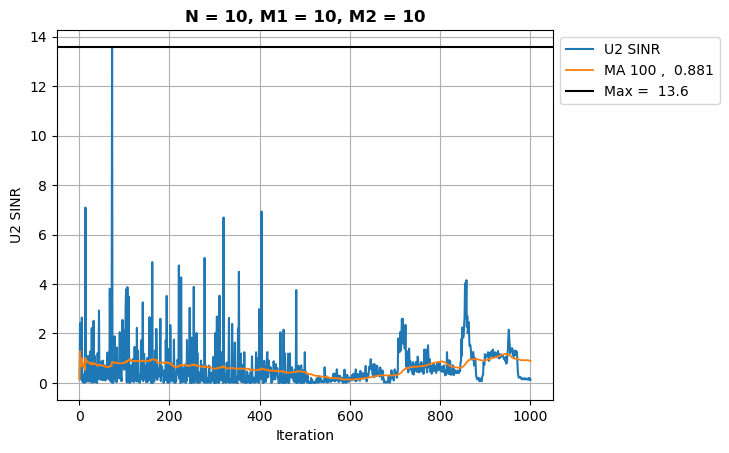

/home/danesh/Desktop/IRS-Project/src/plot.py:144: RuntimeWarning: divide by zero encountered in log10
  np.log10(u2_sinr), linewidth=1.5, label='U2 SINR')


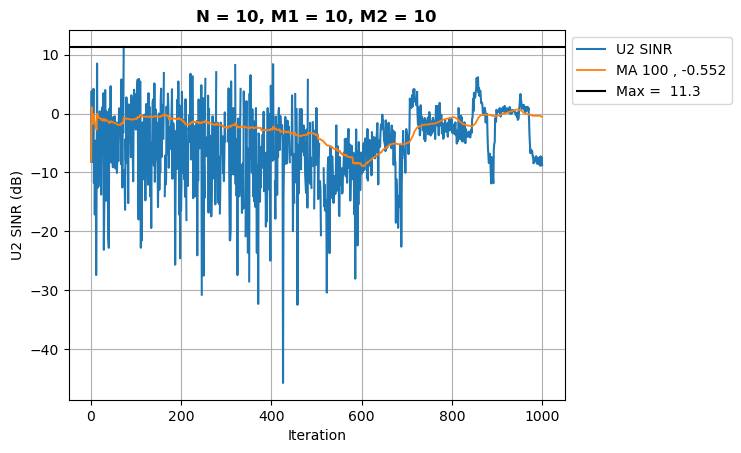

In [9]:
agent = run(50, 100, env=env1)

Agent is Learning :) : 100%|███████████████████████████████████████████████████████████| 4000/4000 [02:24<00:00, 27.63it/s]


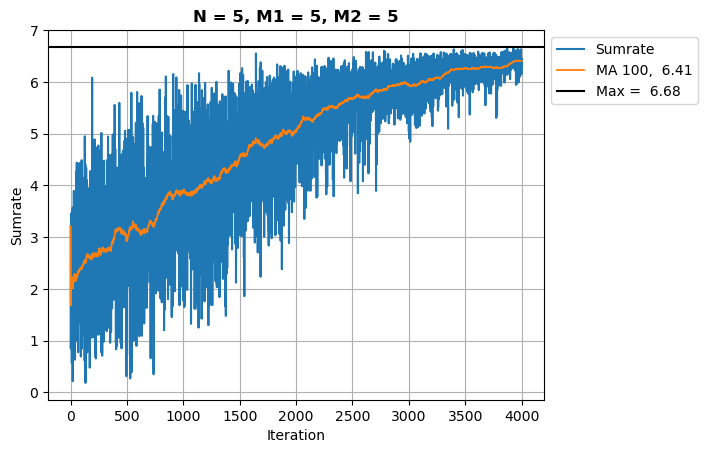

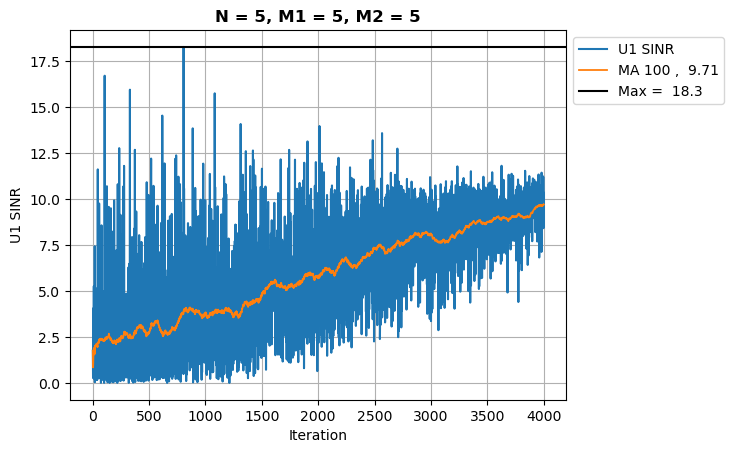

/mnt/c/Users/danes/Desktop/IRS-Project/src/plot.py:88: RuntimeWarning: divide by zero encountered in log10
  np.log10(u1_sinr), linewidth=1.5, label='U1 SINR')


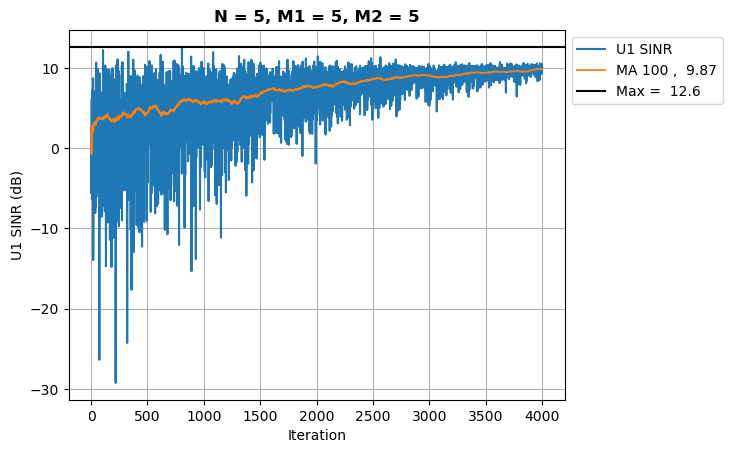

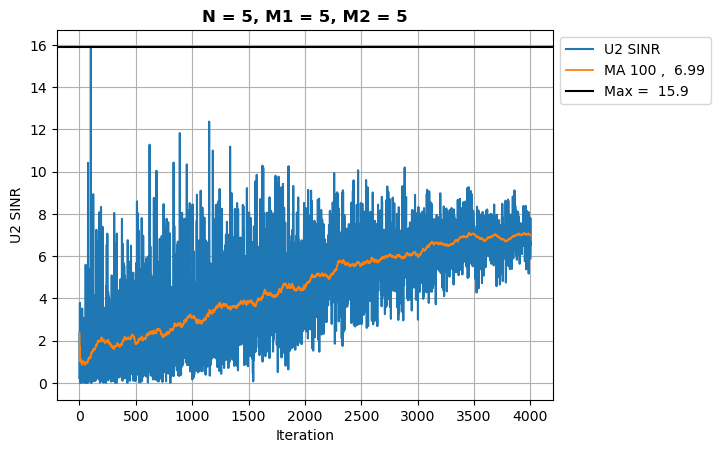

/mnt/c/Users/danes/Desktop/IRS-Project/src/plot.py:144: RuntimeWarning: divide by zero encountered in log10
  np.log10(u2_sinr), linewidth=1.5, label='U2 SINR')


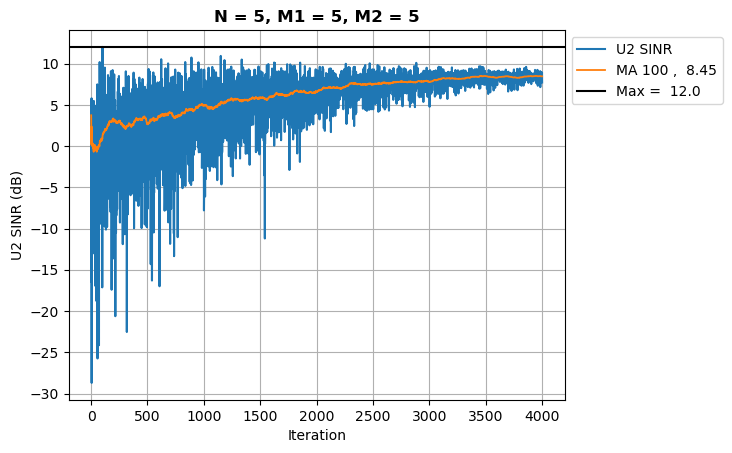

In [14]:
agent2 = run2(4000, env=env1, agent=agent1)

In [ ]:
print(np.diag(np.angle(env.Psi1, deg=True)))
print("************************************************************************************")
print(np.diag(np.angle(env.Psi2, deg=True)))
print("************************************************************************************")
print(max(sumrate.reshape(num_of_episodes*num_of_iterations,)))

[  5.80351911 102.90995479 123.30667377  60.71778774  78.84238601]
************************************************************************************
[1.80000000e+02 1.80000000e+02 1.79999979e+02 1.78838679e+02
 6.44566103e-04]
************************************************************************************
6.4951752893006685


In [19]:
print(np.linalg.norm(U11.w)**2 + np.linalg.norm(U21.w)**2)
print(U11.allocated_power , U21.allocated_power)

1.0
0.661805272102356 0.33819472789764404


In [20]:
print(env1.SINR, env1.SumRate)
print(env2.SINR, env2.SumRate)

[0.2652820995073582, 0.17401050085416228] 0.5709043877762723
[9.236396393587345, 13.060078571613898] 7.169168766793404


In [6]:
import numpy as np
import tensorflow as tf
a = np.ones((1,2))
a
b = tf.constant(a)

In [51]:
env2.Hs1 = np.array([[-1.39157845e-02+0.04802448j,  4.98723797e-02+0.00357012j,
          4.57167136e-02+0.02024801j, -9.75271044e-07+0.05j      ,
          4.97876445e-02+0.00460331j],
        [-4.84736046e-02+0.01226008j, -4.75942272e-02-0.01532284j,
          3.20963206e-02+0.03833831j,  6.73209425e-03-0.04954472j,
         -1.05288236e-02-0.04887887j],
        [ 1.36146597e-02+0.04811072j, -3.60587687e-02+0.03463763j,
         -4.53044742e-02-0.02115431j, -4.40752055e-02+0.02360882j,
         -1.44311023e-02-0.04787216j],
        [-4.22683540e-02+0.02670929j,  1.53889205e-02+0.0475729j ,
          4.96757565e-02+0.005685j  , -3.85290239e-02+0.03186714j,
         -1.40337813e-02-0.04799013j],
        [-4.91778961e-02-0.00902965j, -3.63454091e-02-0.03433673j,
         -4.92973144e-02-0.00835313j, -5.25563359e-03-0.04972302j,
         -4.76884975e-02-0.01502688j]])

env2.Hs2 = np.array([[ 0.00771954+0.03242715j, -0.0049861 -0.03295831j,
         -0.00374419+0.03312238j,  0.03079735+0.01275282j,
         -0.0071466 -0.03255821j],
        [ 0.02033193+0.02641446j,  0.00311422-0.03318754j,
          0.02324321+0.02389277j, -0.02144829-0.02551631j,
         -0.0258206 -0.02108098j],
        [-0.00967346-0.03189883j, -0.02598846-0.02087369j,
         -0.02409072+0.02303797j,  0.02313057-0.02400183j,
          0.00233047-0.03325177j],
        [-0.02463432-0.02245576j,  0.02376565+0.02337317j,
          0.01498286-0.02977625j, -0.02501869-0.02202672j,
          0.00616734-0.03275782j],
        [ 0.0117273 -0.03120227j, -0.01602094+0.02923082j,
          0.00397334+0.03309568j,  0.02993896-0.01465503j,
          0.0299354 -0.0146623j ]])


env2.H12 = np.array([[-0.01160611+0.02214268j, -0.02496921+0.00124038j,
         -0.01467783+0.02023762j,  0.00682238+0.02405109j,
         -0.02421769-0.0062051j ],
        [ 0.02348206-0.00857862j,  0.01426761+0.02052889j,
         -0.02380184-0.00764672j,  0.01999038-0.01501282j,
          0.01738457+0.01796599j],
        [-0.01238819+0.0217148j ,  0.01403245+0.02069034j,
          0.01703498+0.0182978j , -0.02498258-0.00093309j,
          0.02435191+0.00565548j],
        [-0.02456087+0.00466513j,  0.00580584-0.0243165j ,
         -0.02224717-0.01140453j,  0.01676392+0.01854646j,
         -0.02302196+0.00974625j],
        [ 0.02269704+0.01048066j, -0.01566254+0.01948551j,
          0.01064944-0.02261834j,  0.01416104+0.02060255j,
          0.02001837+0.01497547j]])


env2.H21 = np.array([[-0.01160611-0.02214268j,  0.02348206+0.00857862j,
         -0.01238819-0.0217148j , -0.02456087-0.00466513j,
          0.02269704-0.01048066j],
        [-0.02496921-0.00124038j,  0.01426761-0.02052889j,
          0.01403245-0.02069034j,  0.00580584+0.0243165j ,
         -0.01566254-0.01948551j],
        [-0.01467783-0.02023762j, -0.02380184+0.00764672j,
          0.01703498-0.0182978j , -0.02224717+0.01140453j,
          0.01064944+0.02261834j],
        [ 0.00682238-0.02405109j,  0.01999038+0.01501282j,
         -0.02498258+0.00093309j,  0.01676392-0.01854646j,
          0.01416104-0.02060255j],
        [-0.02421769+0.0062051j ,  0.01738457-0.01796599j,
          0.02435191-0.00565548j, -0.02302196-0.00974625j,
          0.02001837-0.01497547j]])


env2.Psi1 = np.array([[-0.999986  -0.00529091j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ],
        [ 0.        +0.j        , -0.34527467-0.93850168j,
          0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.99212333+0.12526495j,  0.        +0.j        ,
          0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        , -0.24409146-0.96975222j,
          0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ,
          0.2647416 -0.96431939j]])

env2.Psi2 = np.array([[-0.99529805-0.09685968j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ],
        [ 0.        +0.j        , -0.74457959+0.6675337j ,
          0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.29635851+0.95507677j,  0.        +0.j        ,
          0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.88662796-0.46248336j,
          0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ,
         -0.53906467+0.84226438j]])

U12.h1u = np.array([[ 0.00083847-0.01998242j, -0.01136959-0.01645395j,
          0.01943746+0.0047101j , -0.01586966-0.01217184j,
         -0.00981436-0.01742637j]])


U12.hsu = np.array([[-0.01591654-0.01211048j, -0.01598705+0.01201724j,
         -0.00597682-0.01908606j, -0.00349381+0.01969247j,
          0.01996058+0.0012551j ]])

U12.h2u = np.array([[-0.00292863-0.03320443j,  0.02225285+0.02481777j,
          0.00430818+0.03305375j, -0.03228555+0.00829182j,
          0.02772527+0.01850461j]])

U12.w = np.array([[ 0.09734487-0.01240598j],
        [ 0.03206944+0.0919138j ],
        [ 0.08768292-0.06697427j],
        [-0.03901275+0.12082483j],
        [-0.1209271 -0.03911317j]])

U22.h1u =  np.array([[-0.02136848-0.01297644j, -0.00277031+0.02484603j,
         -0.02482945+0.00291521j, -0.01187289+0.02200079j,
          0.00922384-0.0232362j ]])

U22.hsu = np.array([[-0.01602768-0.00457071j,  0.01632651+0.00335005j,
          0.01225691+0.01129363j, -0.01404304-0.00897613j,
          0.00890253-0.01408981j]])

U22.h2u = np.array([[ 0.04884074-0.0107043j ,  0.01581273+0.04743372j,
         -0.04546885+0.02079864j,  0.04535134+0.02105364j,
         -0.02544751+0.0430398j ]])

U22.w = np.array([[-0.10879836+0.05018858j],
        [ 0.08837533-0.07431106j],
        [ 0.09622013-0.06193018j],
        [-0.10188884+0.06048772j],
        [ 0.05499567+0.04633025j]])

env2.CalculateSINR()
print(env2.SINR, env2.SumRate)

print(f"Theta1 : {np.diag(np.angle(env2.Psi1, deg=True))}")
print(f"Theta2 : {np.diag(np.angle(env2.Psi2, deg=True))}")

print(f"Rate 1 : {np.log2(1 + env2.SINR[0])}")
print(f"Rate 2 : {np.log2(1 + env2.SINR[1])}")



[1.6379136654752489, 1.4169128074500914] 2.6725627757280077
Theta1 : [-179.69685177 -110.19856353    7.19605653 -104.12814814  -74.64840081]
Theta2 : [-174.44163469  138.12300139   72.76098256  -27.54747068  122.61998948]
Rate 1 : 1.3993973483540814
Rate 2 : 1.2731654273739264
